# **IMPORTING LIBRARIES**

In [55]:
import pandas as pd
import numpy as np
import string
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.util import ngrams
import nltk
import collections
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# **LOADING DATASET**

In [56]:
df = pd.read_csv('dataset/reviews_compressed.csv')

In [57]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# **DATA CLEANING**

In [58]:
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

df['Text'] = df['Text'].apply(punctuation_removal)

In [59]:
def remove_accented_chars(text):
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

df['Text'] = df.apply(lambda x: remove_accented_chars(x['Text']), axis = 1)

In [60]:
def remove_special_characters(text):
    pat = r'[^a-zA-z0-9]' 
    return re.sub(pat, ' ', text)
 
df['Text'] = df.apply(lambda x: remove_special_characters(x['Text']), axis = 1)

# **FEATURE ENGINEERING**

In [61]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [62]:
df['length'] = df['Text'].apply(len)

In [63]:
def get_polarity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    pol = textblob.sentiment.polarity
    return pol

df['polarity'] = df['Text'].apply(get_polarity)

In [64]:
def get_subjectivity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    subj = textblob.sentiment.subjectivity
    return subj

df['subjectivity'] = df['Text'].apply(get_subjectivity)

In [65]:
df[['length','polarity','subjectivity']].describe()

,length,polarity,subjectivity
count,1000.000000,1000.000000,1000.000000
mean,380.702000,0.233904,0.547689
std,362.620362,0.222177,0.146979
min,56.000000,-1.000000,0.000000
25%,165.000000,0.100776,0.466667
50%,262.500000,0.225000,0.553483
75%,461.500000,0.367405,0.633100
max,4838.000000,1.000000,1.000000


In [66]:
df['char_count'] = df['Text'].apply(len)

In [67]:
df['word_count'] = df['Text'].apply(lambda x: len(x.split()))

In [68]:
df['word_density'] = df['char_count'] / (df['word_count']+1)

In [69]:
punctuation = string.punctuation

df['punctuation_count'] = df['Text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 

In [70]:
df[['char_count','word_count','word_density','punctuation_count']].describe()

,char_count,word_count,word_density,punctuation_count
count,1000.000000,1000.000000,1000.000000,1000.0
mean,380.702000,72.397000,5.117609,0.0
std,362.620362,66.878188,0.397306,0.0
min,56.000000,13.000000,3.500000,0.0
25%,165.000000,32.000000,4.875000,0.0
50%,262.500000,51.000000,5.095238,0.0
75%,461.500000,88.000000,5.327841,0.0
max,4838.000000,854.000000,8.266667,0.0


# **DATA VISUALIZATION**

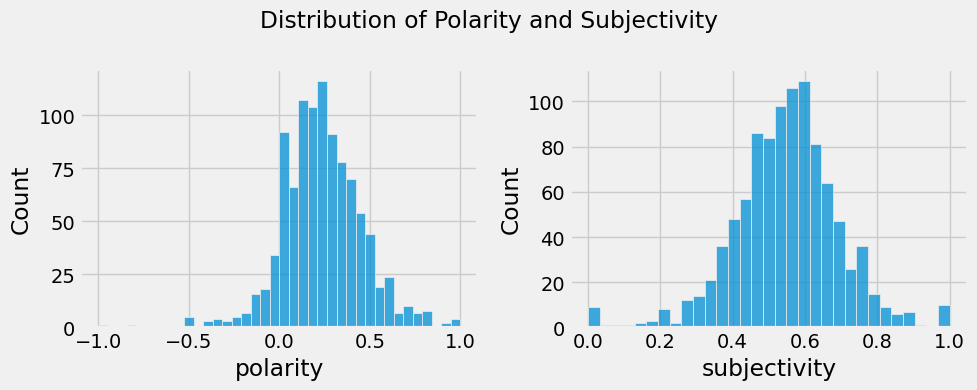

In [71]:
plt.rcParams['figure.figsize'] = (10, 4)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))  

sns.histplot(df['polarity'], ax=ax[0])
sns.histplot(df['subjectivity'], ax=ax[1])

fig.suptitle('Distribution of Polarity and Subjectivity')
plt.tight_layout()  
plt.show()


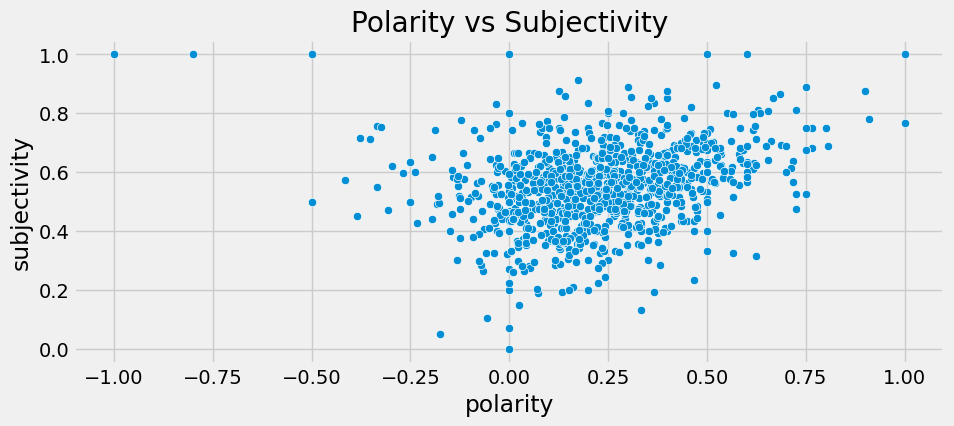

In [72]:
sns.scatterplot(x='polarity', y='subjectivity', data=df)
plt.title('Polarity vs Subjectivity')
plt.show()

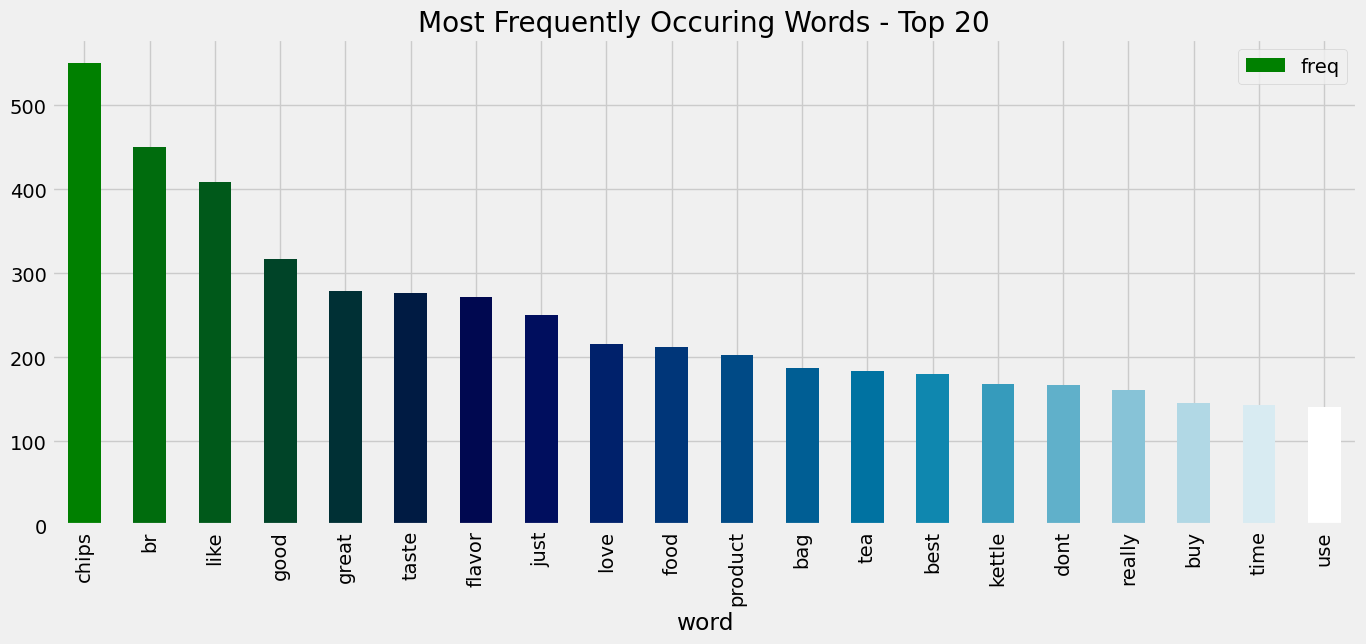

In [73]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.Text)
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

plt.style.use('fivethirtyeight')
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 20")
plt.show()

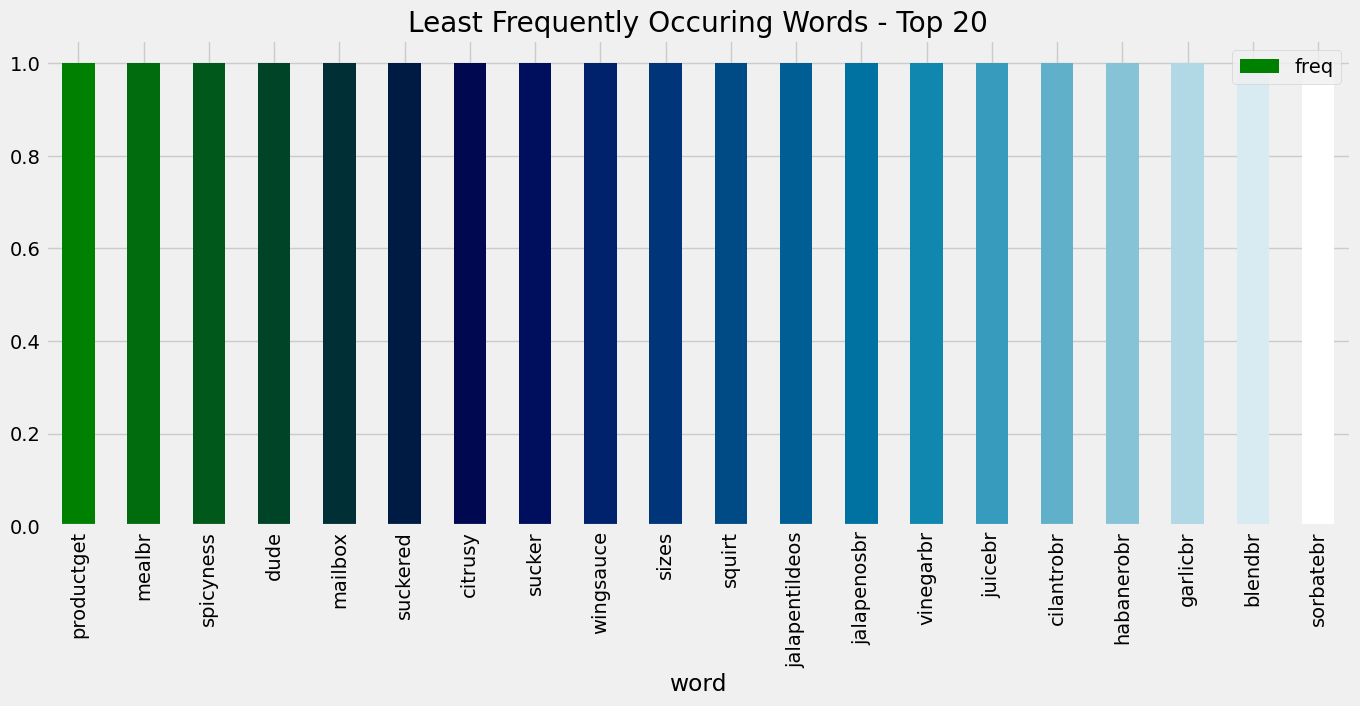

In [74]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.Text)
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

plt.style.use('fivethirtyeight')
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.tail(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Least Frequently Occuring Words - Top 20")
plt.show()

In [75]:
text = str(df['Text'])
tokenized = text.split()

esBigrams = ngrams(tokenized, 2)

esBigramFreq = collections.Counter(esBigrams)

esBigramFreq.most_common(10)

[(('I', 'have'), 2),
 (('for', 'the'), 2),
 (('was', 'a'), 2),
 (('0', 'I'), 1),
 (('have', 'bought'), 1),
 (('bought', 'several'), 1),
 (('several', 'of'), 1),
 (('of', 'the'), 1),
 (('the', 'Vitality'), 1),
 (('Vitality', 'canned'), 1)]

In [76]:
text = str(df['Text'])
tokenized = text.split()

esTrigrams = ngrams(tokenized, 3)

esTrigramFreq = collections.Counter(esTrigrams)

esTrigramFreq.most_common(10)

[(('0', 'I', 'have'), 1),
 (('I', 'have', 'bought'), 1),
 (('have', 'bought', 'several'), 1),
 (('bought', 'several', 'of'), 1),
 (('several', 'of', 'the'), 1),
 (('of', 'the', 'Vitality'), 1),
 (('the', 'Vitality', 'canned'), 1),
 (('Vitality', 'canned', 'd...'), 1),
 (('canned', 'd...', '1'), 1),
 (('d...', '1', 'Product'), 1)]

In [77]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<Axes: >

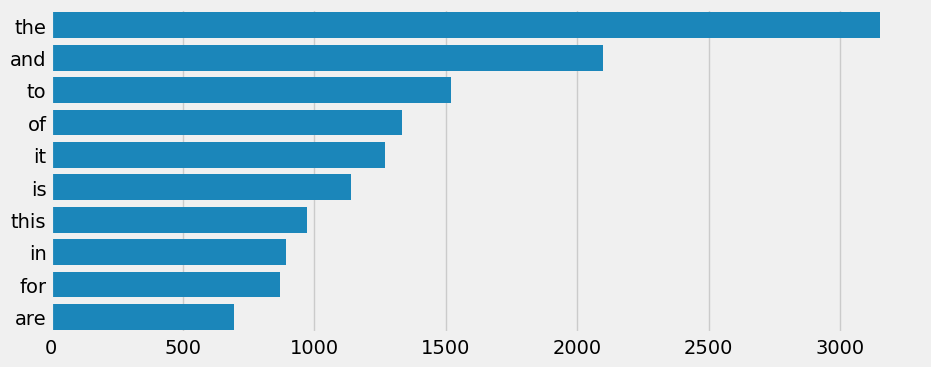

In [78]:
top_unigrams = get_top_ngram(df['Text'],1)[:10]
x,y = map(list,zip(*top_unigrams))
sns.barplot(x = y,y = x)

<Axes: >

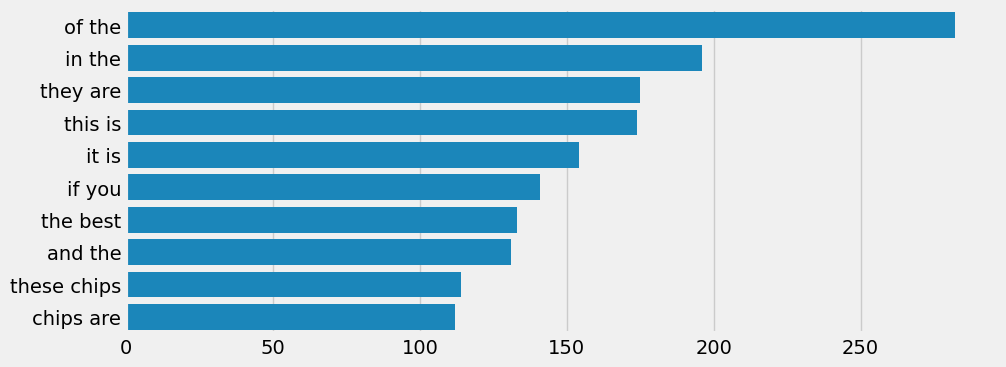

In [79]:
top_bigrams = get_top_ngram(df['Text'],2)[:10]
x,y = map(list,zip(*top_bigrams))
sns.barplot(x = y,y = x)

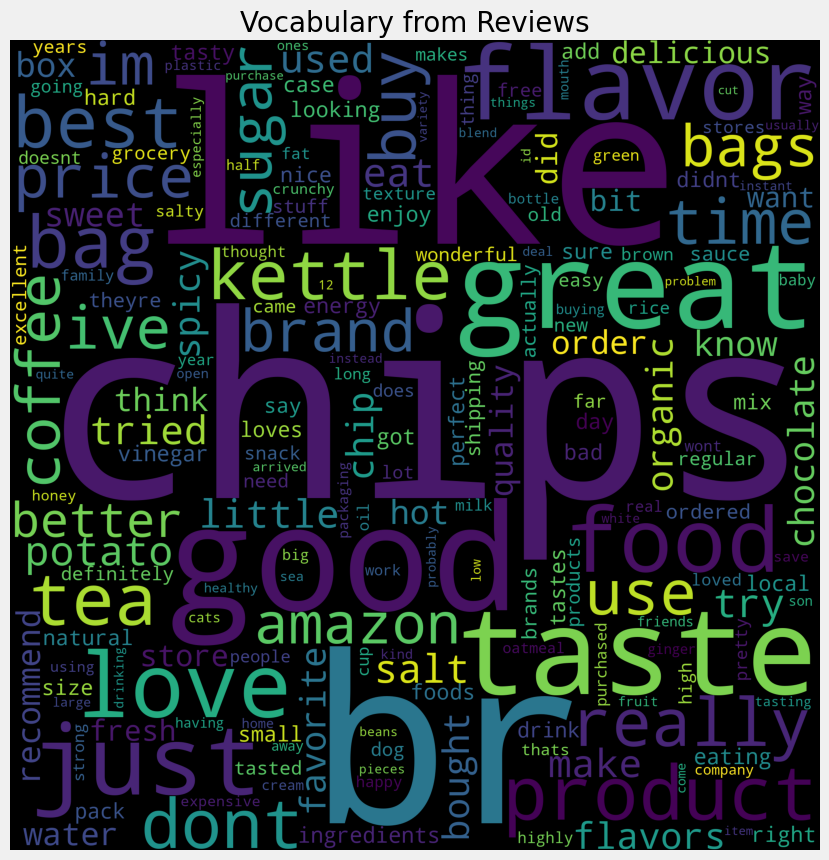

In [80]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.Text)
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

wordcloud = WordCloud(background_color = 'black', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Reviews", fontsize = 20)
plt.show()

# **GENERAL POLARITY OF SPECIFIED KEYWORD**

In [81]:
def get_polarity(text):
    textblob = TextBlob(str(text))
    pol = textblob.sentiment.polarity
    if(pol==0):
        return "Neutral"
    elif(pol>0 and pol<=0.3):
        return "Weakly Positive"
    elif(pol>0.3 and pol<=0.6):
        return "Positive"
    elif(pol>0.6 and pol<=1):
        return "Strongly Positive"
    elif(pol>-0.3 and pol<=0):
        return "Weakly Negative"
    elif(pol>-0.6 and pol<=-0.3):
        return "Negative"
    elif(pol>-1 and pol<=-0.6):
        return "Strongly Negative"
    
df['polarity'] = df['Text'].apply(get_polarity)

In [82]:
df['polarity'].value_counts()

polarity
Weakly Positive      533
Positive             301
Weakly Negative       82
Strongly Positive     48
Neutral               21
Negative              13
Strongly Negative      1
Name: count, dtype: int64

In [83]:
neutral = 0
wpositive = 0
spositive = 0
positive = 0
negative = 0
wnegative = 0
snegative = 0
polarity = 0

for i in range(0,70):
    textblob = TextBlob(str(df['Text'][i]))
    polarity+= textblob.sentiment.polarity
    pol = textblob.sentiment.polarity
    if (pol == 0):  
        neutral += 1
    elif (pol > 0 and pol <= 0.3):
        wpositive += 1
    elif (pol > 0.3 and pol <= 0.6):
        positive += 1
    elif (pol > 0.6 and pol <= 1):
        spositive += 1
    elif (pol > -0.3 and pol <= 0):
        wnegative += 1
    elif (pol > -0.6 and pol <= -0.3):
        negative += 1
    elif (pol > -1 and pol <= -0.6):
        snegative += 1

In [84]:
searchTerm = input("Enter Keyword/Tag to search about: ")
NoOfTerms = int(input("Enter how many reviews to search: "))

In [85]:
polarity = polarity / NoOfTerms
polarity

0.01597360679346821

In [86]:
def percentage(part, whole):
    temp = 100 * float(part) / float(whole)
    return format(temp, '.2f')

In [87]:
positive = percentage(positive, NoOfTerms)
wpositive = percentage(wpositive, NoOfTerms)
spositive = percentage(spositive, NoOfTerms)
negative = percentage(negative, NoOfTerms)
wnegative = percentage(wnegative, NoOfTerms)
snegative = percentage(snegative, NoOfTerms)
neutral = percentage(neutral, NoOfTerms)

In [88]:
print("How people are reacting on " + searchTerm + " by analyzing " + str(NoOfTerms) + " Review.")
print()
print("-----------------------------------------------------------------------------------------")
print()
print("General Report: ")

if (polarity == 0):
    print("Neutral")
elif (polarity > 0 and polarity <= 0.3):
    print("Weakly Positive")
elif (polarity > 0.3 and polarity <= 0.6):
    print("Positive")
elif (polarity > 0.6 and polarity <= 1):
    print("Strongly Positive")
elif (polarity > -0.3 and polarity <= 0):
    print("Weakly Negative")
elif (polarity > -0.6 and polarity <= -0.3):
    print("Negative")
elif (polarity > -1 and polarity <= -0.6):
    print("Strongly Negative")

print()
print("------------------------------------------------------------------------------------------")
print()
print("Detailed Report: ")
print(str(positive) + "% people thought it was positive")
print(str(wpositive) + "% people thought it was weakly positive")
print(str(spositive) + "% people thought it was strongly positive")
print(str(negative) + "% people thought it was negative")
print(str(wnegative) + "% people thought it was weakly negative")
print(str(snegative) + "% people thought it was strongly negative")
print(str(neutral) + "% people thought it was neutral")

How people are reacting on dog food by analyzing 1000 Review.

-----------------------------------------------------------------------------------------

General Report: 
Weakly Positive

------------------------------------------------------------------------------------------

Detailed Report: 
1.80% people thought it was positive
3.80% people thought it was weakly positive
0.50% people thought it was strongly positive
0.20% people thought it was negative
0.50% people thought it was weakly negative
0.00% people thought it was strongly negative
0.20% people thought it was neutral


In [89]:
sizes = [positive, wpositive, spositive, neutral, negative, wnegative, snegative]
colors = ['yellowgreen','lightgreen','darkgreen', 'gold', 'red','lightsalmon','darkred']
labels = ['Positive [' + str(positive) + '%]', 'Weakly Positive [' + str(wpositive) + '%]',
          'Strongly Positive [' + str(spositive) + '%]', 'Neutral [' + str(neutral) + '%]',
          'Negative [' + str(negative) + '%]', 'Weakly Negative [' + str(wnegative) + '%]', 
          'Strongly Negative [' + str(snegative) + '%]']

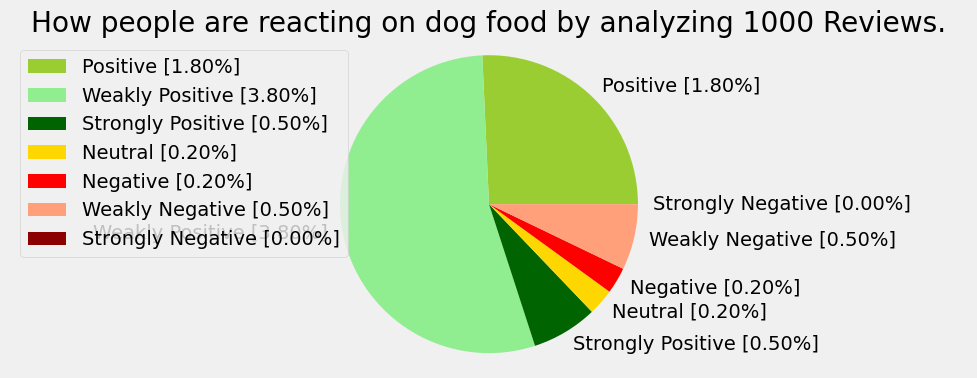

In [90]:
plt.pie(sizes, labels = labels, colors = colors)
plt.legend(labels, loc="best")
plt.title('How people are reacting on ' + searchTerm + ' by analyzing ' + str(NoOfTerms) + ' Reviews.')
plt.axis('equal')
plt.tight_layout()
plt.show()